# Tutorial Auto-Tagging using different front-end/ different architecture

- date: 2024-10-22
- author: geoffroy.peeters@telecom-paris.fr

This notebook was created for the tutorial held at ISMIR-2024 "Deep-Learning 101 for Audio-based Music Information Retrieval".
If you use this notebook, please cite
```
@book{deeplearning-101-audiomir:book,
	author = {Peeters, Geoffroy and Meseguer-Brocal, Gabriel and Riou, Alain and Lattner, Stefan},
	title = {Deep Learning 101 for Audio-based MIR, ISMIR 2024 Tutorial},
	url = {https://geoffroypeeters.github.io/deeplearning-101-audiomir_book},
	address = {San Francisco, USA},
	year = {2024},
	month = November,
	doi = {???},
}
```

It illustrates the use of various deep-learning bricks to solve the task of "Auto-Tagging".

Part of the code is based on 
- SincNet model: https://github.com/mravanelli/SincNet/blob/master/dnn_models.py 

Datasets are available at
- GTZAN-Genre 
- MTT (Magna-Tag-a-Tune) https://mirg.city.ac.uk/codeapps/the-magnatagatune-dataset
- RWC AIST https://staff.aist.go.jp/m.goto/RWC-MDB/AIST-Annotation/ 

The two datasets illustrate different type of problems.
- GTZAN-Genre is a multi-class problem (classification into 10 mutually exclusive classes)
- MTT (Magna-Tag-a-Tune) is a multi-label (classification into 10 non-mutually exclusive tags)
- RWC AIST is a chord-annotation datasets (multi-class over time)

## Deployment

In case the notebook is run on GoogleColab or others, we first need to
- get the packages: `git clone``
- get the datasets

We also test the models on two different datasets:
- GTZAN-Genre
- MTT (Magna-Tag-A-Tune)
- RWC-Popular

In [124]:
do_deploy = False

if do_deploy:
    !git clone https://github.com/geoffroypeeters/deeplearning-101-audiomir_notebook.git
    %cd deeplearning-101-audiomir_notebook
    !ls

    import urllib.request
    import shutil
    ROOT = 'https://perso.telecom-paristech.fr/gpeeters/tuto_DL101forMIR/'
    
    #hdf5_audio_file, pyjama_annot_file = 'gtzan-genre_audio.hdf5.zip', 'gtzan-genre.pyjama'
    #hdf5_audio_file, pyjama_annot_file = 'mtt_audio.hdf5.zip', 'mtt.pyjama'
    hdf5_audio_file, pyjama_annot_file = 'rwc-pop_chord_audio.hdf5.zip', 'rwc-pop_chord_audio.pyjama'
    
    urllib.request.urlretrieve(ROOT + hdf5_audio_file, hdf5_audio_file)
    if hdf5_audio_file.endswith('.zip'): shutil.unpack_archive(hdf5_audio_file, './')
    urllib.request.urlretrieve(ROOT + pyjama_annot_file, pyjama_annot_file)

    ROOT = './'

else:

    ROOT = '/tsi/data_doctorants/gpeeters/_data/'

config_file = 'config_autotagging.yaml'
#config_file = 'config_chord.yaml'

do_wandb = False
import pprint as pp
import yaml
from munch import munchify
with open(config_file, 'r') as fid: 
    cfg_dic = yaml.safe_load(fid)
config = munchify(cfg_dic)
pp.pprint(config)

{'dataset': {'annot_key': 'genre',
             'base': 'gtzan-genre',
             'n_out': 10,
             'problem': 'multiclass'},
 'feature': {'patch_L_frame': 3200,
             'patch_STEP_frame': 1000,
             'type': 'waveform'},
 'model': {'block_l': [{'sequential_l': [{'layer_l': [['LayerNorm',
                                                       {'normalized_shape': [1,
                                                                             3200]}],
                                                      ['Conv1d',
                                                       {'in_channels': 1,
                                                        'kernel_size': 251,
                                                        'out_channels': 80,
                                                        'stride': 15}],
                                                      ['MaxPool1d',
                                                       {'kernel_size': 3,
                

## Import packages

In [125]:
import torch
import torch.nn as nn
import torch.nn.functional as F
#import torchaudio
from torch.utils.data import Dataset
import torch.optim as optim
import torchsummary

! pip install lightning --quiet
import lightning.pytorch as pl
from lightning.pytorch.callbacks import Callback
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint

! pip install wandb --quiet
import wandb
from pytorch_lightning.loggers import WandbLogger

import json
import yaml
import h5py
import pprint as pp
from tqdm import tqdm
import datetime
from multiprocessing import Pool
import os

import librosa
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]
import IPython.display

# -----------------------------
import model_factory 
import feature
import importlib
importlib.reload(model_factory) 
importlib.reload(feature) 

from argparse import Namespace
! pip install munch --quiet
from munch import munchify

## Set fixed seed for reproducibility

In [126]:
import random
import torch
seed = 42
torch.manual_seed(seed)         # For CPU
random.seed(seed)               # For Python's built-in random module
np.random.seed(seed)            # For NumPy
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)          # For current GPU
    torch.cuda.manual_seed_all(seed) 

## Parameters

In [127]:
hdf5_audio_file = f'{ROOT}/{config.dataset.base}_audio.hdf5'
pyjama_annot_file = f'{ROOT}/{config.dataset.base}.pyjama'

param_model = Namespace()
if config.dataset.problem == 'segment': 
    param_model.batch_size = 32
else:
    param_model.batch_size = 128
param_model.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

param_lightning = Namespace()
param_lightning.max_epochs = 500
param_lightning.patience = 10
param_lightning.dirpath='_autotagging_lighning/'
param_lightning.filename='best_model_autotagging'

## Dataloader

### Test loading pyjama/hdf5

All the audio data of a dataset are stored in a single [.hdf5](https://docs.h5py.org/) file.
Each `key` corresponds to an entry, a specific audiofile.
Its array contains the audio wavform and the attribute `sr_hz` provides its sampling rate.

All the annotations of a dataset are stored in a single *.pyjama file.
As [JAMS](https://github.com/marl/jams) files, .pyjama files are JSON files.
However, a single .pyjama file can contain the annotations of ALL entries of a dataset.
Its specifications are described here [DOC](https://github.com/geoffroypeeters/pyjama).
The values of the `filepath` field of the .pyjama file correspond to the `key` values of the .hdf5 file.

We want to solve `multi-class` and `multi-label` problem with the same code. However, in the former we have only one label per item while we can have several for the later. TO deal with this we define the functions `f_get_labelname_dict` and `f_get_groundtruth_item` that provides the list of unique labels and the labels of a given item.

In [128]:
def f_get_labelname_dict(data_d, annot_key):
    """
    description:
        provides the dictionary of labelname used in a given corpus
    """
    labelname_dict_l = []
    for entry in data_d['collection']['entry']:
        for annot in entry[annot_key]:
            labelname_dict_l.append(annot['value'])
    labelname_dict_l = list(set(labelname_dict_l))
    return sorted(labelname_dict_l)

def f_get_groundtruth_item(entry, annot_key, labelname_dict_l, problem, time_sec_v):
    """
    description:
        map a label (or a list of labels) to a ground-truth
    """
    if problem=='multiclass':
        annot = entry[annot_key][0]
        idx_label = labelname_dict_l.index(annot['value'])
    elif problem=='multilabel':
        idx_label = np.zeros(len(labelname_dict_l))
        for annot in entry[annot_key]:
            pos = labelname_dict_l.index(annot['value'])
            idx_label[ pos ] = 1
    elif problem=='segment':
        idx_label = np.zeros(time_sec_v.shape, dtype=int)
        for segment in entry[annot_key]:
            pos = np.where((segment['time'] < time_sec_v) & (time_sec_v <= segment['time'] + segment['duration']))
            if pos[0].size > 0:
                idx_label[pos] = labelname_dict_l.index(segment['value'])
    return idx_label


In [129]:
with open(pyjama_annot_file, encoding = "utf-8") as json_fid:
    data_d = json.load(json_fid)
entry_l = data_d['collection']['entry']

#pp.pprint(entry_l[0:2])


audiofile_l = [entry['filepath'][0]['value'] for entry in entry_l]
print(f'number of audio: {len(audiofile_l)}')
pp.pprint(audiofile_l[:5])


labelname_dict_l = f_get_labelname_dict(data_d, config.dataset.annot_key)
print(f'number of tags: {len(labelname_dict_l)}')
pp.pprint(labelname_dict_l[:5])


with h5py.File(hdf5_audio_file, 'r') as hdf5_fid:
    #audiofile_l = [key for key in hdf5_fid['/'].keys()]
    pp.pprint(f"audio shape: {hdf5_fid[audiofile_l[0]][:].shape}")
    pp.pprint(f"audio sample-rate: {hdf5_fid[audiofile_l[0]].attrs['sr_hz']}")


number of audio: 1000
['blues+++blues.00000.wav',
 'blues+++blues.00001.wav',
 'blues+++blues.00002.wav',
 'blues+++blues.00003.wav',
 'blues+++blues.00004.wav']
number of tags: 10
['blues', 'classical', 'country', 'disco', 'hiphop']
'audio shape: (661794,)'
'audio sample-rate: 22050'


In [130]:
if config.dataset.problem=='segment':
    print( data_d['collection']['entry'][0] )
    labelname_dict_l = f_get_labelname_dict(data_d, config.dataset.annot_key)
    print(len(labelname_dict_l))
    time_sec_v = np.arange(0,205,0.1)
    idx_label = f_get_groundtruth_item(data_d['collection']['entry'][0], config.dataset.annot_key, labelname_dict_l, config.dataset.problem, time_sec_v)

    fig, axes = plt.subplots(1, 1, figsize=(10, 6))
    axes.plot(time_sec_v, idx_label)
    axes.set_xlim(0,10)
    axes.set_yticks(np.arange(0,len(labelname_dict_l)))
    axes.set_yticklabels(labelname_dict_l)
    axes.grid(True)

### Define features

We define the feature that will be used as input to the model, the `X`, and test it on an audio file.
We will use here Log-Mel-Spectrogram provided by the function `feature.f_get_lms`.

blues+++blues.00050.wav
(1, 661794)


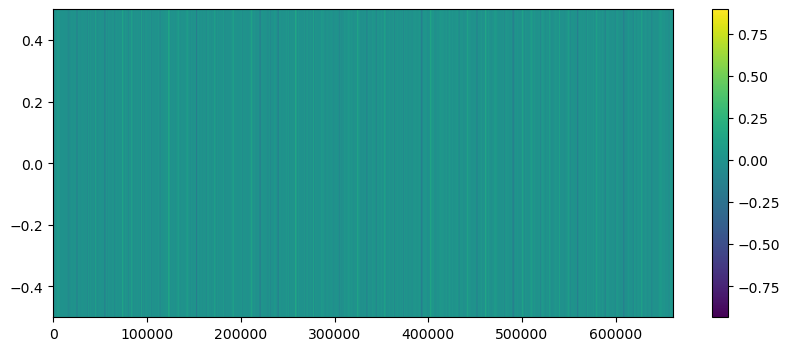

In [131]:
# --- TEST
idx_file = 50
with h5py.File(hdf5_audio_file, 'r') as hdf5_fid:
    print(audiofile_l[idx_file])
    audio_v = hdf5_fid[audiofile_l[idx_file]][:]
    sr_hz = hdf5_fid[audiofile_l[idx_file]].attrs['sr_hz']

if config.feature.type == 'waveform':
    data_m, time_sec_v = feature.f_get_waveform(audio_v, sr_hz)
elif config.feature.type == 'lms':
    data_m, time_sec_v = feature.f_get_lms(audio_v, sr_hz, config.feature)
    data_m = data_m.squeeze(0)
elif config.feature.type == 'hcqt':
    data_m, time_sec_v, frequency_hz_v = feature.f_get_hcqt(audio_v, sr_hz, config.feature)
    data_m = data_m.squeeze(0)

plt.figure(figsize=(10,4))
print(data_m.shape)
plt.imshow(data_m, origin='lower', aspect='auto'); plt.colorbar();

#### Defining patches

The input `X` of our model is actually a temporal patch/chunk of the whole feature matrix `(nb_time, nb_dim)`.
For a given feature matrix of length `total_len`, the function `feature.f_get_patches` provides the list of possible patches of length `patch_len` and hop size `patch_hopsize` (we perform frame-analysis over the feature matrix).


In [132]:
# --- TEST
feature.f_get_patches(total_len=250, patch_len=64, patch_hopsize=32)

[{'start_frame': 0, 'end_frame': 64},
 {'start_frame': 32, 'end_frame': 96},
 {'start_frame': 64, 'end_frame': 128},
 {'start_frame': 96, 'end_frame': 160},
 {'start_frame': 128, 'end_frame': 192},
 {'start_frame': 160, 'end_frame': 224}]

### Create Dataset

The class `TagDataset` (a subset of pytorch `Dataset` class) is responsible for providing (with the `__getitem` method) the input `X` and ground-truth `y` of the pitches existing in a patch.

- `__getitem__`: for a given `idx_patch`, it provides the `X` (either a patch of CQT or Harmonic-CQT) tensor and the ground-truth binary pitch matrix 
- '__init__': 
  - will read the hdf5_feat_file and pyjama_annot_file
  - split their content according to training and test
  - convert the tag annotations to the format expected for `y`
  - store all the necessary data in memory (of CPU) to fasten later access: `self.data_d[key=audiofile]` for the CQT/H-CQT, `self.patch_l` for the list of all possible patch over all possibe audiofile. The `__getitem__` method simply get a patch, which audiofile it is coming from, and its position within it. 

In [133]:
from tqdm import tqdm

class TagDataset(Dataset):
    """
    description
    """

    def __init__(self, hdf5_audio_file, pyjama_annot_file, do_train):

        with open(pyjama_annot_file, encoding = "utf-8") as json_fid: data_d = json.load(json_fid)
        entry_l = data_d['collection']['entry']
        
        self.labelname_dict_l = f_get_labelname_dict(data_d, config.dataset.annot_key)

        self.do_train = do_train
        if self.do_train:   entry_l = [entry_l[idx] for idx in range(len(entry_l)) if (idx % 5) != 0]
        else:               entry_l = [entry_l[idx] for idx in range(len(entry_l)) if (idx % 5) == 0]
        
        self.audio_file_l =  [entry['filepath'][0]['value'] for entry in entry_l]

        self.data_d = {}
        self.patch_l = []
        
        with h5py.File(hdf5_audio_file, 'r') as audio_fid:
            for idx_entry, entry in enumerate(tqdm(entry_l)):
                audio_file= entry['filepath'][0]['value']

                # --- get features
                if config.feature.type == 'waveform':    
                    #feat_value_m, time_sec_v = feature.f_get_waveform(audio_v, sr_hz)
                    feat_value_m = audio_fid[audio_file][:].reshape(1,-1)
                    time_sec_v = np.arange(0,2)/audio_fid[audio_file].attrs['sr_hz']
                elif config.feature.type == 'lms':
                    audio_v, sr_hz =  audio_fid[audio_file][:], audio_fid[audio_file].attrs['sr_hz']
                    feat_value_m, time_sec_v = feature.f_get_lms(audio_v, sr_hz, config.feature)
                elif config.feature.type == 'hcqt':
                    audio_v, sr_hz =  audio_fid[audio_file][:], audio_fid[audio_file].attrs['sr_hz']
                    feat_value_m, time_sec_v, frequency_hz_v = feature.f_get_hcqt(audio_v, sr_hz, config.feature)

                if idx_entry==0: 
                    print(f'A patch corresponds to {np.mean(np.diff(time_sec_v))*config.feature.patch_L_frame} sec.')
                
                # --- map annotations
                idx_label = f_get_groundtruth_item(entry, config.dataset.annot_key, self.labelname_dict_l, config.dataset.problem, time_sec_v)
                
                # --- store for later use
                self.data_d[audio_file] = {'X': torch.tensor(feat_value_m).float(), 'y': torch.tensor(idx_label)}
                
                # --- create list of patches and associate information
                localpatch_l = feature.f_get_patches(feat_value_m.shape[-1], config.feature.patch_L_frame, config.feature.patch_STEP_frame)
                for localpatch in localpatch_l:
                    self.patch_l.append({'audiofile': audio_file,
                                        'start_frame': localpatch['start_frame'],
                                        'end_frame': localpatch['end_frame'],
                                        })

    def __len__(self):
        return len(self.patch_l)

    def __getitem__(self, idx_patch):
        audiofile = self.patch_l[idx_patch]['audiofile']        
        s = self.patch_l[idx_patch]['start_frame']
        e = self.patch_l[idx_patch]['end_frame']
        
        if config.feature.type == 'waveform':    
            # --- X is (C, nb_time)
            X = self.data_d[ audiofile ]['X'][:,s:e]
        elif config.feature.type in ['lms', 'hcqt']:  
            # --- X is (C, nb_dim, nb_time)
            X = self.data_d[ audiofile ]['X'][:,:,s:e]
        
        if config.dataset.problem in ['multiclass', 'multilabel']:
            y = self.data_d[ audiofile ]['y'] # --- We suppose the same annotation for the whole file
        else:
            y = self.data_d[ audiofile ]['y'][s:e] # --- Segment
        return {'X':X , 'y':y}
    
train_dataset = TagDataset(hdf5_audio_file, pyjama_annot_file, do_train=True)
valid_dataset = TagDataset(hdf5_audio_file, pyjama_annot_file, do_train=False)

A patch corresponds to 0.14512471655328799 sec.


100%|██████████| 800/800 [00:07<00:00, 106.39it/s]


A patch corresponds to 0.14512471655328799 sec.


100%|██████████| 200/200 [00:02<00:00, 97.66it/s] 


527468
torch.Size([1, 3200]) torch.float32
torch.Size([]) torch.int64


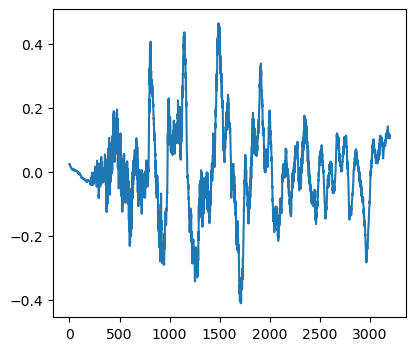

In [134]:
# --- TEST
print(len(train_dataset))
print(train_dataset[0]['X'].shape, train_dataset[0]['X'].dtype)
print(train_dataset[0]['y'].shape, train_dataset[0]['y'].dtype)

idx = 20
plt.figure(figsize=(10,4));
if config.feature.type == 'waveform':
    plt.subplot(121); plt.plot(train_dataset[idx]['X'].squeeze(0));
elif config.feature.type in ['lms', 'hcqt']:  
    plt.subplot(121); plt.imshow(train_dataset[idx]['X'].squeeze(0), aspect='auto', origin='lower'); plt.colorbar();
if config.dataset.problem == 'segment':
    plt.subplot(122); plt.plot(train_dataset[idx]['y']);

### Create DataLoader

We create the dataloader for the training and validation data from the corresponding dataset.


In [135]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=param_model.batch_size, shuffle=True, num_workers=8, drop_last = True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=param_model.batch_size, shuffle=False, num_workers=8, drop_last = True)

In [136]:
# --- TEST
batch = next(iter(train_dataloader))
print(batch['X'].size())
print(batch['y'].size())

torch.Size([128, 1, 3200])
torch.Size([128])


## Model

The pytorch model is generated automatically based on the content of the `config_autotagging.yaml` file.

In [137]:
importlib.reload(model_factory) 
with open(config_file, 'r') as fid: cfg_dic = yaml.safe_load(fid)
config = munchify(cfg_dic)

config.model.block_l[-1].sequential_l[-1].layer_l[-1][1].out_features  = config.dataset.n_out

if config.feature.type == 'waveform':
    m, C, T = param_model.batch_size, 1, config.feature.patch_L_frame
    model = model_factory.NetModel(config, [m, C, T])
if config.feature.type in ['lms', 'hcqt']:
    m, C, H, W = param_model.batch_size, 1, config.feature.nb_band, config.feature.patch_L_frame
    model = model_factory.NetModel(config, [m, C, H, W])

model = model.to(param_model.device)

### Check the model

We can check the model either using
- print(model)
- the `verbose` mode of the `forward` of the model
- the `torchsummary.summary` method

In [138]:
# --- TEST
if config.feature.type == 'waveform':
    m, C, T = param_model.batch_size, 1, config.feature.patch_L_frame

    X = torch.randn(m, C, T).to(param_model.device)
    print(model(X, True).size())
    
    #torchsummary.summary(model, input_size=(C, T))

if config.feature.type in ['lms', 'hcqt']:
    m, C, H, W = param_model.batch_size, 1, config.feature.nb_band, config.feature.patch_L_frame

    X = torch.randn(m, C, H, W).to(param_model.device)
    print(model(X, True).size())

    #torchsummary.summary(model, input_size=(C, H, W))

0/0---------------------------------
Sequential(
  (0): LayerNorm((1, 3200), eps=1e-05, elementwise_affine=True)
  (1): Conv1d(1, 80, kernel_size=(251,), stride=(15,), padding=valid)
  (2): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (3): LayerNorm((80, 65), eps=1e-05, elementwise_affine=True)
  (4): LeakyReLU(negative_slope=0.01)
  (5): Dropout(p=0, inplace=False)
)
> in: torch.Size([128, 1, 3200])
> out: torch.Size([128, 80, 65])
0/1---------------------------------
Sequential(
  (0): Conv1d(80, 60, kernel_size=(5,), stride=(1,), padding=valid)
  (1): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (2): LayerNorm((60, 20), eps=1e-05, elementwise_affine=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Dropout(p=0, inplace=False)
)
> in: torch.Size([128, 80, 65])
> out: torch.Size([128, 60, 20])
0/2---------------------------------
Sequential(
  (0): Conv1d(60, 60, kernel_size=(5,), stride=(1,), padding=valid)
  (1): MaxPo

### Test the model

We can also test the model and the loss, i.e. checking that the format of the `X` corresponds to what the model is expected; and the format of the `y` and `hat_y` corresponds to what the loss is expected.
If this is OK we can start training.

In [139]:
model.to(param_model.device)
batch = next(iter(train_dataloader))
X = batch['X'].to(param_model.device)
y = batch['y'].to(param_model.device)
hat_y = model(X)
print(f'{X.size()} {y.size()} {hat_y.squeeze(1).size()}')
print(f'{X.dtype} {y.dtype} {hat_y.squeeze(1).dtype}')

torch.Size([128, 1, 3200]) torch.Size([128]) torch.Size([128, 10])
torch.float32 torch.int64 torch.float32


In [140]:
def do_reshape_segment(hat_y, y, C=25):
    """
    reshape in case of sequences of labels
    """
    # --- hat_y (batch_size, C, len_sequence) -> (batch_size, len_sequence, C)
    hat_y = hat_y.permute(0, 2, 1).contiguous()
    return hat_y.reshape(-1, C), y.reshape(-1)

In [141]:
if config.dataset.problem == 'multiclass': 
    nn.CrossEntropyLoss()(hat_y, y)
elif config.dataset.problem == 'segment': 
    hat_y , y = do_reshape_segment(hat_y, y)
    print(f'{y.size()} {hat_y.squeeze(1).size()}')
    nn.CrossEntropyLoss()(hat_y, y)
elif config.dataset.problem=='multilabel': 
    nn.BCEWithLogitsLoss(reduction='none')(hat_y.squeeze(1), y).size()

## Training using TorchLightning

### TorchLightning

In [142]:
def get_accuracy(hat_y_prob, y_idx):
    """ Manually compute accuracy """
    hat_y_idx = torch.argmax(hat_y_prob, dim=1)  # Get the predicted class (index of max logit)
    correct = (hat_y_idx == y_idx).float()  # Compare with ground truth and cast to float
    accuracy = correct.sum() / len(correct)  # Compute mean accuracy over the batch
    return accuracy

class AutoTaggingLigthing(pl.LightningModule):
    def __init__(self, in_model):
        super().__init__()
        self.model = in_model
        if config.dataset.problem=='multiclass':    self.loss = nn.CrossEntropyLoss()
        elif config.dataset.problem == 'segment':   self.loss = nn.CrossEntropyLoss()
        elif config.dataset.problem=='multilabel':  self.loss = nn.BCEWithLogitsLoss()

    def training_step(self, batch, batch_idx):
        hat_y_prob = self.model(batch['X'])
        if config.dataset.problem == 'segment': hat_y_prob, y_idx = do_reshape_segment(hat_y_prob, batch['y'])
        else: y_idx = batch['y']
        
        loss = self.loss(hat_y_prob, y_idx)

        self.log("train_loss", loss, prog_bar=True)
        if config.dataset.problem in ['multiclass', 'segment']:
            accuracy = get_accuracy(hat_y_prob, y_idx)
            self.log('train_acc', accuracy, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        hat_y_prob = self.model(batch['X'])
        if config.dataset.problem == 'segment': hat_y_prob, y_idx = do_reshape_segment(hat_y_prob, batch['y'])
        else: y_idx = batch['y']
        
        loss = self.loss(hat_y_prob, y_idx)
        
        self.log('val_loss', loss, prog_bar=True)
        if config.dataset.problem==['multiclass', 'segment']:
            accuracy = get_accuracy(hat_y_prob, y_idx)
            self.log('val_acc', accuracy, prog_bar=True)

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), 0.01)
        return optimizer

### Training

We train the model and apply a early-stopping based on the validation loss. We also monitor the accuracy.

In [143]:
my_lighting = AutoTaggingLigthing( model )
early_stop_callback = EarlyStopping(monitor="val_loss", patience=param_lightning.patience, verbose=True, mode="min")
checkpoint_callback = ModelCheckpoint(monitor='val_loss', dirpath=param_lightning.dirpath, filename=param_lightning.filename, save_top_k=1, mode='min')
trainer = pl.Trainer(accelerator="gpu",  max_epochs = param_lightning.max_epochs, callbacks = [early_stop_callback, checkpoint_callback])
trainer.fit(model=my_lighting, train_dataloaders=train_dataloader, val_dataloaders=valid_dataloader)

/home/ids/gpeeters/anaconda3/envs/conda_gpeeters_2024/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/ids/gpeeters/anaconda3/envs/conda_gpeeters_202 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/ids/gpeeters/anaconda3/envs/conda_gpeeters_2024/lib/python3.8/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /home/ids/gpeeters/proj_tuto-ISMIR2024/code/_autotagging_lighning exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | model | NetModel         | 124 K 
1 | loss  | CrossEntropyLoss | 0     
------------------------------

Epoch 0: 100%|██████████| 4120/4120 [00:37<00:00, 109.50it/s, v_num=91, train_loss=1.320, train_acc=0.516]

/home/ids/gpeeters/anaconda3/envs/conda_gpeeters_2024/lib/python3.8/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [144]:
if config.dataset.problem == 'segment':
    batch = next(iter(train_dataloader))
    
    model = model.to(param_model.device)
    X = batch['X'].to(param_model.device)
    y_idx = batch['y'].to(param_model.device)
    hat_y_prob = model(X)

    idx = 1
    plt.figure(figsize=(12,6));
    plt.subplot(121); 
    plt.imshow(X[idx].cpu().numpy().squeeze(0), aspect='auto', origin='lower'); plt.xlabel('Time')
    
    axes = plt.subplot(122);
    axes.imshow(hat_y_prob[idx].detach().cpu().numpy(), aspect='auto', origin='lower', interpolation=None); plt.xlabel('Time')
    axes.plot(y_idx[idx].cpu().numpy(), 'w', label='ground-truth'); 
    axes.plot(hat_y_prob[idx].argmax(axis=0).detach().cpu().numpy(), 'r--', label='predicted')
    axes.legend()
    axes.set_yticks(np.arange(0,len(valid_dataset.labelname_dict_l)))
    axes.set_yticklabels(valid_dataset.labelname_dict_l)
    axes.grid(True)
    
    

## Evaluation

We first load the best model obtained during training.

In [145]:
best_model_path = checkpoint_callback.best_model_path
print(f"Best model saved at: {best_model_path}")
my_lighting = AutoTaggingLigthing.load_from_checkpoint(best_model_path, in_model=model)

print( type(model) )
print( type(my_lighting) )
print( type(my_lighting.model) )

model = my_lighting.model
model.to(param_model.device)

Best model saved at: 


IsADirectoryError: [Errno 21] Is a directory: '/home/ids/gpeeters/proj_tuto-ISMIR2024/code'

### Multi-class/Segment/Multi-label: performance measures using scikitlearn

We send all the data of the validation dataset to the model, get the estimated pitch `hat_y`.

- For **multiclass**, we then choose the most-likely class for each item `np.argmax` and compute the `recall`, `precision`, `f-measure`, `accuracy`.
- For **segment**, we do the same after concatenating all decisions over time of a given patch
- For **multilabel**, we preserve the probability outputs, and evaluate the results for various possible threshold using the `roc_auc_score` and `average_precision_score`.


In [146]:
if config.dataset.problem in ['multiclass', 'segment']:
    y_idx_l = []
    hat_y_idx_l = []
    for batch in valid_dataloader:
        hat_y_prob = model(batch['X'].to(param_model.device))
        if config.dataset.problem == 'segment': hat_y_prob, y = do_reshape_segment(hat_y_prob, batch['y'])
        else: y = batch['y']
        y_idx_l.append(y)        
        hat_y_idx_l.append(np.argmax(hat_y_prob.detach().cpu().numpy(), axis=1))

    y_idx_v = np.concatenate(y_idx_l)
    hat_y_idx_v = np.concatenate(hat_y_idx_l)
    print(y_idx_v.shape)
    print(hat_y_idx_v.shape)

    from sklearn.metrics import classification_report, confusion_matrix
    classification_reports = classification_report(y_true=y_idx_v, y_pred=hat_y_idx_v, output_dict=True, zero_division=0)
    pp.pprint(classification_reports['macro avg'])
    cm = confusion_matrix(y_true=y_idx_v, y_pred=hat_y_idx_v)
    print(cm)
    # --- accuracy: np.sum(np.diag(cm))/np.sum(cm)
    # --- recall: for c in range(10): print(cm[c,c]/np.sum(cm[c,:]))

elif config.dataset.problem=='multilabel':
    y_ohe_l = []
    hat_y_prob_l = []
    for batch in valid_dataloader:
        hat_y_prob = F.sigmoid(model(batch['X'].to(param_model.device)))
        if config.dataset.problem=='multiclass':       y_ohe_l.append(F.one_hot(batch['y'], 10).numpy())
        elif config.dataset.problem=='multilabel':     y_ohe_l.append(batch['y'].numpy())
        hat_y_prob_l.append(hat_y_prob.detach().cpu().numpy())
    y_ohe_m = np.concatenate(y_ohe_l) # --- convert list to array
    hat_y_prob_m = np.concatenate(hat_y_prob_l)

    # --- remove classes that do not appear in the validation set
    mask = np.sum(y_ohe_m, axis=0)>0
    y_ohe_m = y_ohe_m[:,mask]
    hat_y_prob_m = hat_y_prob_m[:,mask]

    from sklearn.metrics import roc_auc_score, average_precision_score
    auc = roc_auc_score(y_true=y_ohe_m, y_score=hat_y_prob_m, average="macro")
    print(f'auc: {auc}')
    average_precision = average_precision_score(y_true=y_ohe_m, y_score=hat_y_prob_m, average="macro")
    print(f'average_precision: {average_precision}')

(131840,)
(131840,)
{'f1-score': 0.42430432826578723,
 'precision': 0.43413529906425063,
 'recall': 0.43661054722367226,
 'support': 131840.0}
[[ 6060  1042   718   468   292  2498   372   323   784   623]
 [  259 11225   131    92     6  1219     7   176    22    47]
 [ 2501   848  3353   660   279  2404   437   744   592  1369]
 [ 1449   474   680  3594   991  1330   602  1270  1346  1452]
 [ 1611   296   308  1304  4278  1208  1020  1201  1674   314]
 [ 1309  2736   268   256   162  7444   135   389   230   259]
 [ 1247    23   311   441   344   604  8369   104   213  1524]
 [  553   584   430   706  1133  1387   139  6907   900   441]
 [ 1611   516   889   911  1212  2535   193  1234  3728   351]
 [ 1812  1034  1966   992   478  1748   899   924   700  2606]]


### Illustration: tag-o-gram

We illustrate the results obtained by the trained model on a given audio.

torch.Size([206, 10])


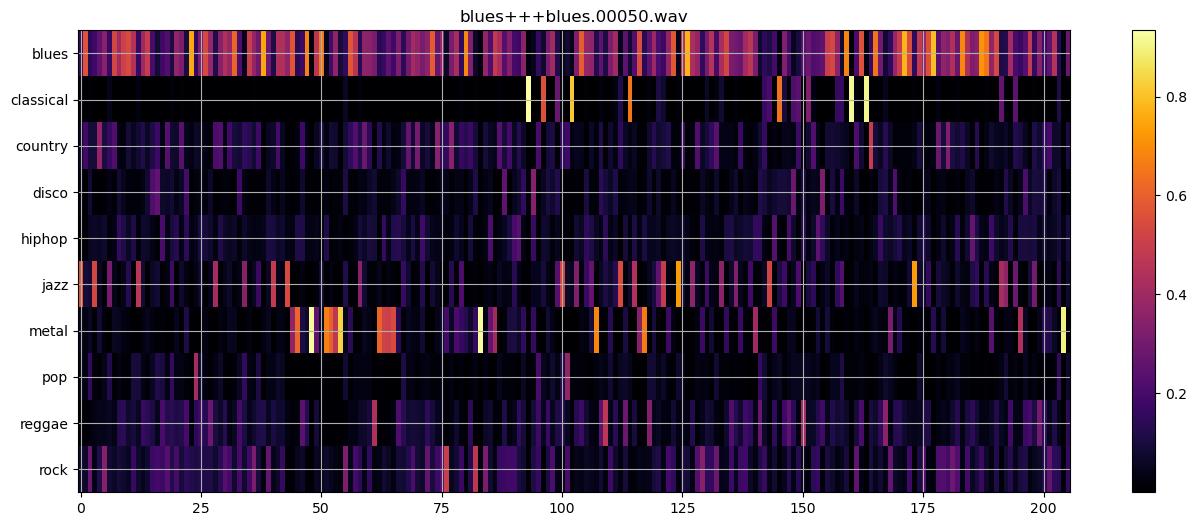

In [147]:
def F_tag_o_gram(model, audio_v, sr_hz):
    """
    """
    # --- Compute the audio features
    if config.feature.type == 'waveform':    feat_value_m, _ = feature.f_get_waveform(audio_v, sr_hz)
    elif config.feature.type == 'lms':       feat_value_m, _ = feature.f_get_lms(audio_v, sr_hz, config.feature)
    elif config.feature.type == 'hcqt':      feat_value_m, _, _ = feature.f_get_hcqt(audio_v, sr_hz, config.feature)
    
    # --- Split matrix into patches
    nb_frame = feat_value_m.shape[1]
    # --- WARNING: we remove overlap between patches by setting STEP_frame=L_frame
    patch_info_l = feature.f_get_patches(feat_value_m.shape[-1], config.feature.patch_L_frame, config.feature.patch_L_frame)
    nb_patch = len(patch_info_l)
    
    data_l = []
    for patch_info in patch_info_l:
        if config.feature.type == 'waveform': 
            data_l.append(feat_value_m[:, patch_info['start_frame']:patch_info['end_frame']])
        elif config.feature.type in ['lms', 'hcqt']: 
            data_l.append(feat_value_m[:, :, patch_info['start_frame']:patch_info['end_frame']])
    
    data_m = np.asarray(data_l)
    # --- Convert numpy to torch tensor
    X = torch.from_numpy(data_m).float().to(param_model.device)

    # --- Get prediction from model
    model.eval()
    hat_y_prob = model(X)
    print(hat_y_prob.shape)
    if config.dataset.problem == 'segment': 
        hat_y_prob = hat_y_prob.permute(0, 2, 1).contiguous().reshape(-1, 25)
        
    if config.dataset.problem in ['multiclass', 'segment']: hat_y_prob = F.softmax(hat_y_prob, dim=1)
    elif config.dataset.problem=='multilabel':     hat_y_prob = F.sigmoid(hat_y_prob)
    # --- Convert from torch tensor to numpy
    hat_y_prob_np = hat_y_prob.cpu().detach().numpy()
    
    fig, axes = plt.subplots(1, 1, figsize=(16, 6))
    im = axes.imshow(hat_y_prob_np.T, aspect='auto', interpolation=None, cmap=plt.get_cmap('inferno'))
    axes.set_yticks(np.arange(0,len(valid_dataset.labelname_dict_l)))
    axes.set_yticklabels(valid_dataset.labelname_dict_l)
    axes.grid(True)
    fig.colorbar(im, orientation='vertical')

    return


# ---------------------------------------------
# ---------------------------------------------
# ---------------------------------------------
audio_file= valid_dataset.audio_file_l[10]

with h5py.File(hdf5_audio_file, 'r') as audio_fid:
    audio_value_v = audio_fid[audio_file][:]
    audio_sr_hz = audio_fid[audio_file].attrs['sr_hz']
F_tag_o_gram(model, audio_value_v, audio_sr_hz)
plt.title(audio_file)
IPython.display.Audio(data=audio_value_v, rate=audio_sr_hz)

In [ ]:
import shutil
shutil.copy(config.output_file.origin, config.output_file.origin + config.output_file.ext)

### Display learned filters Conv1D

Parameter containing:
tensor([[[-0.6323, -0.3729, -0.5686,  ..., -0.3991, -0.4197, -0.1881]],

        [[-0.0087,  0.3434,  0.3658,  ..., -0.6205, -1.4911, -1.2485]],

        [[-0.1255, -0.3692, -0.2829,  ..., -0.7355, -0.4331,  0.0788]],

        ...,

        [[ 0.6876, -0.6194, -1.2620,  ...,  0.3399,  1.3921,  0.2786]],

        [[ 0.2797, -0.0022, -0.1136,  ..., -0.1565, -0.0450, -0.0549]],

        [[-0.0788, -0.0715,  0.0753,  ...,  0.2703,  0.2508,  0.5130]]],
       device='cuda:0', requires_grad=True)

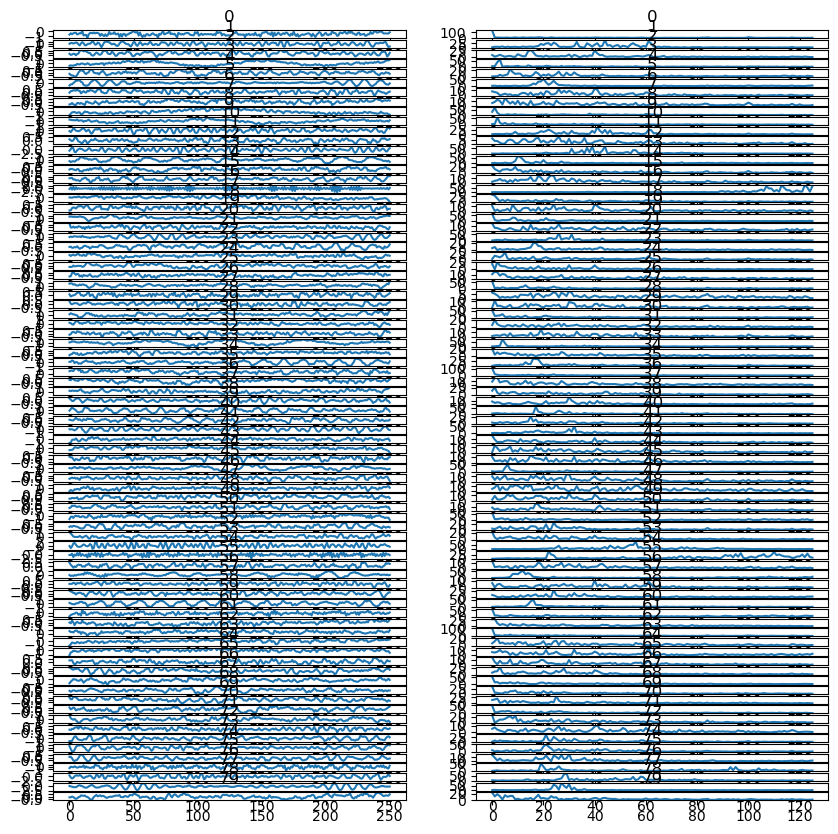

In [151]:
# --- Disaply Conv1D filter
named_modules_dict = dict(model.named_modules())
weight = named_modules_dict['model.0'][0][1].weight # --- Conv1D


# --- Display SincNet filters
#named_modules_dict = dict(model.named_modules())
#weight = named_modules_dict['model.0'][0][1].filters # --- SincNet

plt.figure(figsize=(10,10))
nb_filter = weight.size()[0]
for num_filter in range(nb_filter):
    value = weight[num_filter,:,:].squeeze().detach().cpu() 
    plt.subplot(nb_filter, 2, 2*num_filter+1)
    plt.plot( value ); plt.title(num_filter)
    plt.subplot(nb_filter, 2, 2*num_filter+2)
    plt.plot(np.abs(np.fft.rfft(value)) ); plt.title(num_filter)

### Display learned filters SincNet

In [ ]:
import shutil
shutil.copy(config.output_file.origin, config.output_file.origin + config.output_file.ext)